## Prerequisites

The implementation, training and hyperparameter optimization of the models require the following libraries:
- scikit-optimize
- numpy
- pytorch
- pickle
- matplotlib
- tqdm

In [1]:
import skopt
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import numpy as np
from skopt.plots import plot_convergence
import torch
import pickle as pk
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# Sequence generation capacity benchmark

In this jupyter notebook we provide the code for our comparative study on the question of sequence generation capacity using RNNs. This benchmark compares different RNN models by measuring how many sequential patterns these models can generate. 

## Dataset
The generation task involves continuous 2D trajectories of length 60 coming from a handmade dataset. An example trajectory from this dataset is represented here:

In [2]:
trajs = pk.load(open('data/hard_trajectories_250.pk', 'rb'))
trajs = trajs[:, ::20].transpose(1, 0, 2)
trajs.shape

(60, 250, 2)

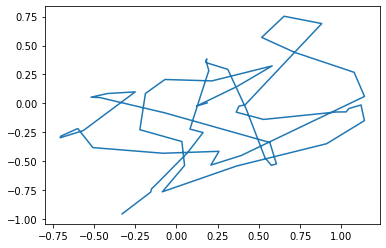

In [3]:
k = np.random.randint(250)
plt.plot(trajs[:, k, 0], trajs[:, k, 1])
plt.show()


This study compares well known RNN models and learning schemes:
- **sRNN** : Simple RNN model
- **TRNN** : Temporal RNN where the hidden state dynamics are controlled by a time constant $\tau$
- **MTRNN** : Hierarchy of several TRNNs with slower time constants in the upper layers
- **LSTM** : Long Short-Term Memory, RNN model using three gating mechanisms
- **GRU** : Gated Recurrent Unit, RNN model using two gating mechanisms
- **UGRNN** : Update Gate RNN, RNN model using one gating mechanism
- **Antisymmetric RNN** : RNN model with antisymmetric recurrent weights that improve backpropagation
- **ESN** : Echo State Network, RNN model where only the output weights are trained

As well as RNN designed by our hands based on the Predictive Coding theory:
- **PC-RNN-V** : The *Vanilla* version of our PC-RNN models, it corresponds to a TRNN with feedback mechansisms
- **PC-RNN-GC** : PC-RNN model using another layer encoding the velocity of the hidden layer, inspired from the idea of Generalized Coordinates
- **PC-RNN-HC-A** : PC-RNN model using Additive Hidden Causes, similar to the idea of parametric bias
- **PC-RNN-HC-M** : PC-RNN model using Multiplicative Hidden Causes, where the input conditions the recurrent matrix in a fashion similar to the Multiplicative RNN
- **PC-RNN-GC-HC-A** : PC-RNN model combining Additive Hidden Causes and Generalized Coordinates
- **PC-RNN-GC-HC-M** : PC-RNN model combining Multiplicative Hidden Causes and Generalized Coordinates

Implementations of these models are available in the files advances_rnn_models.py and pc_rnn_models.py.

## Training

The models are trained using the BPTT algorithm for 3000 iterations over the data set.

## Hyperparameter optimization

Hyperparameters for each model are found using Bayesian optimization with Gaussian processes and a Matern 5/2 Kernel. The idea is to fix the model size and to optimize the number of trajectories that the model can encode properly. In the following example, we set the hidden dimension of the network to 60.
For a given model, we first define the parameters to optimize and their bounds:

In [4]:
# For the PC-RNN-HC-A model, we optimize the number of trajectories for a given model size, the learning rate and the time constant of the model

from pc_rnn_models import PC_RNN_HC_A

opt_p = Integer(low=1, high=250, prior='uniform', name='opt_p')
opt_lr = Real(low=1e-4, high=1e0, prior='log-uniform', name='opt_lr')
opt_tau_h = Real(low=1, high=100, prior='log-uniform', name='opt_tau_h')

dimensions = [opt_p, opt_lr, opt_tau_h]

We define the default hyperparameters to initialize the search:

In [5]:
default_parameters = [5, 0.01, 10]

We define the fitness function depending on these parameters that the optimizer will try to minimize:

In [6]:
# Training iterations for each hyperparameter configuration
iterations = 3000

# Number of hyperparameter configurations tried
configurations = 300

# Number of attempt per hyperparameter optimization (to lower the variance of the measure)
n_tries = 2

# We store the final count of properly generated sequences
counts = np.zeros((configurations, n_tries))

conf_id = np.zeros(1)

@use_named_args(dimensions=dimensions)
def fitness(opt_p, opt_lr, opt_tau_h):
    
    print("Configuration " + str(int(conf_id)) + ' :')
    print("p = " + str(opt_p))
    print("lr = " + str(opt_lr))
    print("tau_h = " + str(opt_tau_h))
    
    global p, lr, tau_h
    
    p = np.int32(opt_p)
    lr = np.float32(opt_lr)
    tau_h = np.float32(opt_tau_h)

    for tr in range(n_tries):

        rnn = PC_RNN_HC_A(p, 60, 2, alpha_x=0, tau_h=tau_h, alpha_h=0)
        h_init = torch.nn.Parameter(torch.randn(p, rnn.states_dim))
        c_init = torch.eye(rnn.causes_dim)
        rnn.w_o = torch.nn.Parameter(rnn.w_o)
        rnn.b_o = torch.nn.Parameter(rnn.b_o)
        rnn.w_c = torch.nn.Parameter(rnn.w_c)
        rnn.w_r = torch.nn.Parameter(rnn.w_r)
        rnn.b_r = torch.nn.Parameter(rnn.b_r)
        opt=torch.optim.Adam((rnn.w_o, rnn.w_c, rnn.w_r, rnn.b_o, rnn.b_r), lr=lr)

        # Shuffle the dataset
        l = np.arange(250)
        np.random.shuffle(l)
        l = l[:p]
        
        # Training
        for i in range(iterations):
            opt.zero_grad()
            error = rnn.forward(torch.Tensor(trajs[:, l]), c_init=c_init, h_init=h_init, store=False)
            loss = torch.mean(error**2)
            loss.backward()
            opt.step()   

        # Evaluation
        error = rnn.forward(torch.Tensor(trajs[:, l]), c_init=c_init, h_init=h_init, store=False)
        count = np.sum(np.mean(np.sqrt(np.sum(error.detach().numpy()**2, axis=2)), axis=0)<0.1)
    
        counts[int(conf_id), tr] = count
        
    mean_count = np.mean(counts[int(conf_id)])
    
    conf_id[0] = conf_id[0] + 1
        
    print(2*mean_count - p)
    print("=======================================")
    
    return p - 2*mean_count

In [ ]:
print("This can take a very long time, you can instead use the saved results available in this repo. To do so, exectute the next cell instead of this one.")

search_result = gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func='EI',
    n_calls=configurations,
    x0=default_parameters
)

Configuration 0 :
p = 5
lr = 0.01
tau_h = 10
5.0
Configuration 1 :
p = 23
lr = 0.010006856756615978
tau_h = 5.983845830007782


In [7]:
# Here are the search results we obtained for this model and this size
search_result = pk.load(open('results/hp_opt/PC_RNN_HC_A_models_60.pk', 'rb'))

The hyperparameter optimizer estimates a function associating a score with any hyperparameter configuration. Here we try to find the optimum of this function:

In [8]:
from utils import val_to_i, i_to_val, cartesian

print("This can take a few seconds...")

# Resolution of the grid to search for the optimum
res = 50

# Definition of the grid
x = cartesian((np.arange(res), np.arange(res), np.arange(res)))/res

# Find the optimum
y, _ = search_result.models[-1].predict(X=x, return_std=True)
argmin_x = np.argmin(y)

# Retrieve the corresponding hyperparameter values
argmin_p, argmin_lr, argmin_tau_h = x[argmin_x]
optimal_p = i_to_val(argmin_p, 1, 1, 250, log=False)
optimal_lr = i_to_val(argmin_lr, 1, 1e-4, 1e0)
optimal_tau_h = i_to_val(argmin_tau_h, 1, 1, 100)

print(optimal_p)
print(optimal_lr)
print(optimal_tau_h)

This can take a few seconds...
60.76
0.017378008287493762
4.786300923226384


We can further tune these found hyperparameters by using a higher resolution separately on each axis. This is particularly needed for models with more hyperparameters, since the resolution of the complete search is restricted for memory reasons.


## Evaluation of the model using the optimal hyperparameters

Using the hyperparameters we have found, we can now evaluate the average number of sequence patterns that are properly generated by the model.

In [9]:
# Number of seeds for the measure, in the article we used 10 seeds for each measure
seeds=3

# Found hyperparameters
lr=optimal_lr
p=round(optimal_p)
tau_h=optimal_tau_h

# Training iterations
iterations = 3000

# We store the prediction errors and counts of encoded patterns
prediction_errors = np.zeros((seeds, iterations))
counts = np.zeros(seeds)

for s in tqdm(range(seeds)):
    
    l = np.arange(250)
    np.random.shuffle(l)
    l = l[:p]

    rnn = PC_RNN_HC_A(p, 60, 2, alpha_x=0, tau_h=tau_h, alpha_h=0)
    h_init = torch.nn.Parameter(torch.randn(p, rnn.states_dim))
    c_init = torch.eye(rnn.causes_dim)
    rnn.w_o = torch.nn.Parameter(rnn.w_o)
    rnn.b_o = torch.nn.Parameter(rnn.b_o)
    rnn.w_c = torch.nn.Parameter(rnn.w_c)
    rnn.w_r = torch.nn.Parameter(rnn.w_r)
    rnn.b_r = torch.nn.Parameter(rnn.b_r)
    opt=torch.optim.Adam((rnn.w_o, rnn.w_c, rnn.w_r, rnn.b_o, rnn.b_r), lr=lr)

    # Training
    for i in range(iterations):
        opt.zero_grad()
        error = rnn.forward(torch.Tensor(trajs[:, l]), c_init=c_init, h_init=h_init, store=False)
        loss = torch.mean(error**2)
        prediction_errors[s, i] = loss.detach().item()
        loss.backward()
        opt.step()   

    # Evaluation
    error = rnn.forward(torch.Tensor(trajs[:, l]),c_init=c_init, h_init=h_init, store=False)
    count = np.sum(np.mean(np.sqrt(np.sum(error.detach().numpy()**2, axis=2)), axis=0)<0.1)
    counts[s] = count

  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
print('Estimated number of trajectories correctly learned by the model:')
print(np.mean(counts))

Estimated number of trajectories correctly learned by the model:
48.666666666666664


With this process, we have estimated the number of temporal patterns of our data set that can be learned by a PC-RNN-HC-A model of hidden size 60. We have reproduced the same protocol for every model and for different model sizes to obtain the figure shown in our work.

Here is the list of model parameters optimized for each model, and the bounds we have used. For all models, we have optimized the number of trajectories to train on, $p$ which is comprised between 1 and 250:

- **sRNN** : 
    - Learning rate $\lambda$ with bounds (1e-4, 1e0) and logarithmic scale.
- **TRNN** : 
    - Learning rate $\lambda$ with bounds (1e-4, 1e0) and logarithmic scale.
    - Time constant $\tau$ with bounds (1, 100) and logarithmic scale.
- **MTRNN** :
    - Learning rate $\lambda$ with bounds (1e-4, 1e0) and logarithmic scale.
    - Slow time constant $\tau_s$ with bounds (1, 100) and logarithmic scale.
    - Fast time constant $\tau_f$ with bounds (1, 100) and logarithmic scale.
- **LSTM** :
    - Learning rate $\lambda$ with bounds (1e-4, 1e0) and logarithmic scale.
- **GRU** : 
    - Learning rate $\lambda$ with bounds (1e-4, 1e0) and logarithmic scale.
- **UGRNN** :
    - Learning rate $\lambda$ with bounds (1e-4, 1e0) and logarithmic scale.
- **Antisymmetric RNN** :
    - Learning rate $\lambda$ with bounds (1e-4, 1e0) and logarithmic scale.
    - Time constant $\tau$ with bounds (1, 100) and logarithmic scale.
    - Coefficient $\gamma$ with bounds (1e-2, 1e0) and logarithmic scale.
- **ESN** : 
    - Time constant $\tau$ with bounds (1, 100) and logarithmic scale.
    - Connectivity $p$ with bounds (0, 1) and linear scale.
    - Synaptic strength $\sigma$ with bounds (1e-1, 1e1) and logarithmic scale.
- **PC-RNN-V** :
    - Learning rate $\lambda$ with bounds (1e-4, 1e0) and logarithmic scale.
    - Time constant $\tau$ with bounds (1, 100) and logarithmic scale.
- **PC-RNN-GC** :
    - Learning rate $\lambda$ with bounds (1e-4, 1e0) and logarithmic scale.
    - Time constant $\tau$ with bounds (1, 100) and logarithmic scale.
    - Upadate rate coef $\alpha_h'$ with bounds (1e-3, 1e1) and logarithmic scale.
- **PC-RNN-HC-A** :
    - Learning rate $\lambda$ with bounds (1e-4, 1e0) and logarithmic scale.
    - Time constant $\tau$ with bounds (1, 100) and logarithmic scale.
- **PC-RNN-HC-M** :
    - Learning rate $\lambda$ with bounds (1e-4, 1e0) and logarithmic scale.
    - Time constant $\tau$ with bounds (1, 100) and logarithmic scale.
- **PC-RNN-GC-HC-A** :
    - Learning rate $\lambda$ with bounds (1e-4, 1e0) and logarithmic scale.
    - Time constant $\tau$ with bounds (1, 100) and logarithmic scale.
- **PC-RNN-GC-HC-M** :
    - Learning rate $\lambda$ with bounds (1e-4, 1e0) and logarithmic scale.
    - Time constant $\tau$ with bounds (1, 100) and logarithmic scale.
    
The fitness functions estimated by the hyperparameter optimizer in our experiments can be found in the directory results/hp_opt/. You can use these results and the program shown before to retrieve the best hyperparameters for each (model, model size) pair.